# Indice

Il notebook ha la seguente struttura:
- Introduzione teorica all'equazione di evoluzione dei dischi e alla discretizzazione di Galerkin
- Definizioni di griglia, elementi finiti, calcolo delle matrici $M$ e $A$, integratore temporale di Crank-Nicolson 
- Calcolo della soluzione esatta a partire dalla soluzione fondamentale dell'equazione (con possibili modifiche per stabilità numerica)
- Test iniziale del metodo su soluzione esatta
- Generazione di soluzione fiduciale: dopo validazione con soluzione esatta, faremo test di autoconvergenza
- Analisi di convergenza spaziale
- Analisi di convergenza temporale

Nell'appendice raccolgo:
- Forma esatta di $A$ in un caso particolare che mi è stata utile per debugging
- Convergenza del calcolo di $A$ (determinazione dell'ordine di quadratura gaussiana necessario)
- Test preliminari del metodo su equazione del calore


# Introduzione teorica

### L'equazione di evoluzione dei dischi
L'obiettivo di questo progetto è di risolvere la seguente equazione parabolica nella variabile $\Sigma$:

$$\frac{\partial \Sigma}{\partial t} = \frac{3}{r}\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{1/2}\nu \Sigma.$$

$\Sigma(r,t)$ rappresenta la densità superficiale di massa di un disco di accrescimento assialmente simmetrico, $\nu = A_0 r^{\alpha}/3$ descrive la viscosità (data nei dischi astronomici dall'interazione tra mulinelli di turbolenza) che si prende come una legge di potenza dove alcuni indici di interesse sono $\alpha = 1/2, -3/10$. Con questa scelta l'equazione è lineare e otteniamo:

$$\frac{\partial \Sigma}{\partial t} = \frac{A_0}{r}\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{\alpha+1/2} \Sigma.$$

L'equazione diventa più trattabile passando alla variabile $u=2\pi r \Sigma$, $\Sigma = u/2\pi r$:

$$
\begin{align*}
\frac{\partial}{\partial t}\frac{u}{2\pi r}
&= \frac{A_0}{r}\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{\alpha+1/2}\frac{u}{2\pi r}\\
&= A_0\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{\alpha-1/2}u
\end{align*}
$$

Semplifichiamo:

$$
\begin{align*}
\frac{\partial u}{\partial t} 
&= A_0\frac{\partial}{\partial r}r^{1/2}\frac{\partial}{\partial r}r^{\alpha-1/2}u \\
&= A_0\frac{\partial}{\partial r}
\left[
    r^{1/2}r^{\alpha-1/2}\frac{\partial u}{\partial r}
    +r^{1/2}\left(\frac{\partial}{\partial r}r^{\alpha-1/2}\right)u
\right]\\
&=A_0\frac{\partial}{\partial r}
\left[r^{\alpha} \frac{\partial u}{\partial r} +
    r^{1/2}\left(\alpha-\frac{1}{2}\right)r^{\alpha-3/2} u
\right]\\
&=A_0\frac{\partial}{\partial r}
\left[r^{\alpha} \frac{\partial u}{\partial r} +
    \left(\alpha-\frac{1}{2}\right)r^{\alpha-1} u
\right]
\end{align*}$$

### Forma canonica


Lo portiamo nella forma del Quarteroni che vuole:

$$\frac{\partial u}{\partial t} + L(u) = 0$$
$$L(u) = \frac{\partial}{\partial r}\left(-\mu\frac{\partial u}{\partial r} + b u\right)$$
e quindi 

$$
\begin{align*}
L(u)
&=\frac{\partial}{\partial r}
\left[-A_0r^{\alpha} \frac{\partial u}{\partial r}
    -A_0\left(\alpha-\frac{1}{2}\right)r^{\alpha-1} u
\right]
\end{align*}
$$

$$\mu = A_0r^{\alpha}$$
$$b = -A_0\left(\alpha - \frac{1}{2}\right)r^{\alpha-1}$$



### Coefficiente di trasporto

Notiamo che con questa convenzione, se trascuriamo $\mu$ e consideriamo $b$ costante, $b>0$ implica trasporto verso destra (onda progressiva):

$$\frac{\partial u}{\partial t} + b\frac{\partial u}{\partial r} = 0$$
$$u = u(r-t/b)$$

Un caso semplice è quello $\alpha=0$ in cui abbiamo viscosità costante e trasporto dato da
$$b=\frac{1}{2r}$$

La cosa strana però è che nonostante $b>0$ la soluzione esatta si sposta verso sinistra. Questo mostra che quando i coefficienti non sono costanti l'interpretazione non è banale.

## Il metodo di Galerkin per equazioni paraboliche

### Formulazione debole e sua approssimazione

Prendiamo l'equazione e moltiplichiamola per ogni $t>0$ per una funzione test $v=v(x)$ integrando su $\Omega$.
Lo spazio di funzioni test $V$ è lo spazio di funzioni $H^1(\Omega)$ che si annullano in $x_{min}$ e 1.

L'equazione diventa:

$$\int_{\Omega} \dot{u(t)}v\, d\Omega + a(u(t),v) = 0$$

dove

$$a(u,v) = \int_{\Omega} \left(\mu u' - b u\right)v'\, d\Omega,$$

con il punto che indica la derivata temporale, l'apostrofo la derivata spaziale.

L'approssimazione di Galerkin del problema si ottiene scegliendo in uno spazio $V_h \subset V$ a dimensione finita $N_h$ una base $\{\phi_j\}$:

$$u_h(x,t) = \sum_{j=1}^{N_h} u_j(t)\phi_j(x)$$

così che l'equazione in forma debole diventa

$$\sum_{j=1}^{N_h}\left(
    \dot{u}_j(t) \int_{\Omega} \phi_j \phi_i\, d\Omega + u_j(t) a(\phi_j,\phi_i) = 0
\right)$$

ovvero, definendo il vettore delle incognite $\mathbf{u} = (u_1(t), \dots,u_{N_h}(t))^T$, la matrice di massa $M = [\int_{\Omega} \phi_j \phi_i\,d\Omega]$ e la matrice di rigidezza $A = [a(\phi_j,\phi_i)]$ il sistema può essere riscritto nella forma

$$M\dot{\mathbf{u}(t)} + A\mathbf{u}(t) = 0$$

### Discretizzazione temporale

Discretizziamo l'equazione con il metodo di Crank-Nicolson:

$$M\frac{\mathbf{u}^{k+1}-\mathbf{u}^k}{\Delta t} + \frac{1}{2}A(\mathbf{u}^{k+1}+\mathbf{u}^k) = 0.$$

Il sistema da risolvere è:

$$K\mathbf{u}^{k+1} = \mathbf{g}$$

dove $K = M + A\Delta t/2$, $\mathbf{g} = (M - A\Delta t/2)\mathbf{u}^k$.

# Codice preliminare

### Import

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # barre di caricamento
from numpy.polynomial import Polynomial, polynomial # FE
from scipy.interpolate import lagrange # FE
from numpy.polynomial.legendre import leggauss # quadratura
from scipy.linalg import solve # non usata per ora
from scipy.sparse import csc_matrix # matrici sparse
from scipy.sparse.linalg import spsolve # risolutore sparso
from scipy.sparse.linalg import factorized # fattorizza LU sparso
from scipy.signal import convolve # metodo veloce per alcune funzioni di green
from scipy.optimize import curve_fit
from scipy.special import iv, ive, gamma
from pathlib import Path
from scipy.interpolate import make_splrep # interpolazione
import pickle # salvataggio dati
plt.rcParams.update({ # latex
    "text.usetex": True,
    "font.family": "CM Roman"
})
import subprocess # comandi shell

### Utilità varie

In [78]:
def quad(f,deg,a=0,b=1):
    # quadratura gaussiana
    x, w = leggauss(deg)
    x = (x+1)/2
    w /= 2
    h = (b-a)
    X = a + h*x
    I = w @ f(X) * h
    return I

def LTGdd(ndof,NumEl):
    #matrice local to global per condizioni al contorno di dirichlet
    # -1 1 2 ... k
    # k ... 
    # ... -1
    N = ndof*NumEl-1
    
    # dalla seconda colonna in poi
    right = np.r_[np.arange(N),-1].reshape((-1,ndof))

    # prima colonna
    left = np.r_[-1,right[:-1,-1]].reshape((-1,1))
    return np.c_[left,right]

def assemble_from_LTG(LTG,contribution):
    # costruisce M o A a partire da contributi locali
    # contribution(k,j,l) dove k e j righe e colonne, l indice di x per a=a(x)
    matrix = np.zeros((np.max(LTG)+1,np.max(LTG)+1))
    for l in tqdm(range(LTG.shape[0]),leave=True):
        for k in range(LTG.shape[1]):
            row = LTG[l,k]
            if row<0:
                continue
            for j in range(LTG.shape[1]):
                col = LTG[l,j]
                if col<0:
                    continue
                matrix[row,col] += contribution(k,j,l)
    return matrix

def line(x,m,q):
    return m*x+q

def fix_lims(ax,condition):
    global xlim0, ylim0
    if condition:
        xlim0 = ax.get_xlim()
        ylim0 = ax.get_ylim()
    else:
        ax.set_xlim(xlim0)
        ax.set_ylim(ylim0)

### Griglia e calcolo di $M$

In [69]:
class GRID:
    def __init__(self, a, b, NumEl, scaling="lin",ndof=1,getM=False,fe=None,gaussdeg=None):
        # Inizializza una griglia per metodo di Galerkin
        # precalcola opzionalmente la matrice di massa

        if a>b:
            a, b = b, a 
        self.NumEl = NumEl 
        self.ndof = ndof
        self.DegOfFreedom = ndof*NumEl-1
        if scaling=="lin":
            self.V = np.linspace(a, b, NumEl+1)
        elif scaling=="log": # per ora non lo uso mai
            self.V = np.logspace(a, b, NumEl+1)
        self.ElemSize = np.diff(self.V) #lunghezza degli intervalli
        self.MidPoints = (self.V[:-1]+self.V[1:])/2 #punti medi

        # aggiungi nodi intermedi per elementi di grado > 1
        self.globV = self.V
        for i in range(1,ndof):
            self.globV = np.r_[self.globV,self.V[:-1]+self.ElemSize*i/ndof]
        self.globV = np.sort(self.globV)

        # precalcola la matrice di massa
        if gaussdeg is None:
            gaussdeg = ndof+1 # quadratura esatta per polinomi di grado 2*ndof
        if getM:
            p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
            grigliaref = GRID(0,1,1) #la griglia fatta di un intervallo [0,1]
            self.Mlocal = np.zeros((ndof+1,ndof+1))
            for k in range(ndof+1):
                for j in range(ndof+1):
                    # integrale di phi_k phi_j
                    integranda = lambda x: p[k](x)*p[j](x)*self.ElemSize[0] 
                    self.Mlocal[k,j] = grigliaref.integrate(integranda,deg=gaussdeg)

            # assemblaggio matrice globale
            self.LTG = LTGdd(ndof,NumEl) #già decise condizioni di Dirichlet omogenee
            contribution = lambda k, j, l: self.Mlocal[k,j] 
            self.M = assemble_from_LTG(self.LTG, contribution)
            self.M = csc_matrix(self.M,dtype=float) # matrice sparsa

            
    def integrate(self,f,deg=1):
        # integra una funzione sulla griglia con quadratura gaussiana
        return np.sum([quad(f,deg,a=self.V[i],b=self.V[i+1]) for i in range(self.NumEl)])

### Elemento finito

In [4]:
class FE:
    def __init__(self, ndof):
        self.ndof = ndof
        # nodi locali
        self.Xref = np.linspace(0,1,ndof+1)
        points = 0*self.Xref
        self.Pol = [None]*(ndof+1)
        # definisce i polinomi di Lagrange sui nodi associati
        for i in range(ndof+1):
            points[i] = 1 # il polinomio i-esimo deve valere 1 al nodo i-esimo
            pol = lagrange(self.Xref, points)
            self.Pol[i] = Polynomial(pol.coef[::-1])
            points[i] = 0 # spengo il nodo
        # calcolo derivate
        self.PolDer = [p.deriv() for p in self.Pol]

### Forma quadratica per i dischi

In [98]:
def adisc(u,v,du,dv,xL=0,dx=1,params=1):
    A0 = params
    #v in realtà non viene usata ma almeno c'è chiarezza
    mu = lambda r: r**alpha
    b = lambda r: -(alpha-1/2)*r**(alpha-1)
    xrest = lambda r: xL+r*dx # dà x vero in funzione di x di riferimento
    return lambda r: A0*(mu(xrest(r))*du(r)/dx-b(xrest(r))*u(r))*dv(r)

In [99]:
fe = FE(2)
p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
x = np.linspace(1,10,100)
print(adisc(p[0],p[0],dp[0],dp[0],params=1)(x))


[1.00000000e+00 1.79235537e+00 2.80228862e+00 4.02567887e+00
 5.45950413e+00 7.10149793e+00 8.94992708e+00 1.10034435e+01
 1.32609830e+01 1.57216942e+01 1.83848878e+01 2.12500000e+01
 2.43165649e+01 2.75841942e+01 3.10525620e+01 3.47213922e+01
 3.85904500e+01 4.26595336e+01 4.69284696e+01 5.13971074e+01
 5.60653159e+01 6.09329804e+01 6.60000000e+01 7.12662859e+01
 7.67317591e+01 8.23963499e+01 8.82599955e+01 9.43226403e+01
 1.00584234e+02 1.07044731e+02 1.13704092e+02 1.20562279e+02
 1.27619258e+02 1.34875000e+02 1.42329477e+02 1.49982663e+02
 1.57834535e+02 1.65885072e+02 1.74134255e+02 1.82582066e+02
 1.91228488e+02 2.00073506e+02 2.09117106e+02 2.18359275e+02
 2.27800000e+02 2.37439271e+02 2.47277077e+02 2.57313408e+02
 2.67548256e+02 2.77981612e+02 2.88613467e+02 2.99443815e+02
 3.10472649e+02 3.21699961e+02 3.33125747e+02 3.44750000e+02
 3.56572715e+02 3.68593887e+02 3.80813511e+02 3.93231582e+02
 4.05848097e+02 4.18663051e+02 4.31676441e+02 4.44888262e+02
 4.58298512e+02 4.719071

### Calcolo della matrice $A$

In [ ]:
def getAold(fe,griglia,a,constantdiffusion=False,NgridA=10,gaussdeg=None,params=None):
    #calcola la matrice di rigidezza, a seconda se ci sono diffusione/trasporto non costanti spazialmente
    p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
    NumEl, xL, dx = griglia.NumEl, griglia.V[:-1], griglia.ElemSize
    LTG = LTGdd(ndof,NumEl)
    grigliaref = GRID(0,1,NgridA)
    if gaussdeg is None:
        gaussdeg = max(4,ndof) # sperimentalmente è sufficiente

    # se a non dipende da x
    if constantdiffusion:
        Alocal = np.zeros((ndof+1,ndof+1))
        local_a = lambda j, k, x: a(
            p[j],p[k],
            dp[j],dp[k],
            params=params)(x)
        for k in range(ndof+1):
            for j in range(ndof+1):
                Alocal[k,j] = grigliaref.integrate(lambda x: local_a(j, k, x),deg=gaussdeg)
        contribution = lambda k, j, l: Alocal[k,j] 
    # se a dipende da x
    else:
        full_a = lambda j, k, l, x: a(
            p[j],p[k],
            dp[j],dp[k],
            xL[l],dx[l],
            params=params)(x)
        contribution = lambda k, j, l: grigliaref.integrate(lambda x: full_a(j, k, l, x), deg=gaussdeg)
    
    A = assemble_from_LTG(LTG, contribution)
    A = csc_matrix(A,dtype=float) # matrice sparsa
    return A

In [134]:
def getA(fe, griglia, a, constantdiffusion=False, NgridA=10, gaussdeg=None, params=None):
    """
    Versione vettoriale di getA compatibile con la vecchia funzione,
    velocizza l'integrazione su constantdiffusion=False senza cambiare i valori.
    """
    p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
    NumEl, xL, dx = griglia.NumEl, griglia.V[:-1], griglia.ElemSize
    LTG = LTGdd(ndof, NumEl)
    
    if gaussdeg is None:
        gaussdeg = max(4, ndof)
    
    # Punti e pesi di Gauss su [0,1]
    xg, wg = leggauss(gaussdeg)
    xg = 0.5*(xg + 1.0)
    wg = 0.5*wg

    if constantdiffusion:
        # caso costante: integrazione standard su griglia di riferimento
        grigliaref = GRID(0,1,NgridA)
        Alocal = np.zeros((ndof+1, ndof+1))
        for k in range(ndof+1):
            for j in range(ndof+1):
                fvals = [a(p[j], p[k], dp[j], dp[k], params=params)(x) for x in xg]
                Alocal[k,j] = np.dot(wg, fvals)
        contribution = lambda k, j, l: Alocal[k,j]
    
    else:
        # caso variabile: integrazione elemento per elemento
        Alocal_all = np.zeros((ndof+1, ndof+1, NumEl))
        for l in range(NumEl):
            xx = xL[l] + dx[l]*xg  # punti di quadratura su elemento l
            for k in range(ndof+1):
                for j in range(ndof+1):
                    fvals = a(p[j], p[k], dp[j], dp[k], xL[l], dx[l], params=params)(xx)
                    Alocal_all[k,j,l] = np.dot(wg, fvals)

        contribution = lambda k, j, l: Alocal_all[k,j,l]

    # Assemblaggio matrice globale
    A = assemble_from_LTG(LTG, contribution)
    return csc_matrix(A, dtype=float)


In [132]:
def getA(fe, griglia, a, constantdiffusion=False, NgridA=10, gaussdeg=None, params=None):
    p, dp, ndof = fe.Pol, fe.PolDer, fe.ndof
    NumEl, xL, dx = griglia.NumEl, griglia.V[:-1], griglia.ElemSize
    LTG = LTGdd(ndof, NumEl)

    if gaussdeg is None:
        gaussdeg = max(20, ndof)

    # punti e pesi di Gauss (una volta sola)
    xg, wg = leggauss(gaussdeg)
    xg = 0.5 * (xg + 1.0)
    wg = 0.5 * wg

    if constantdiffusion:
        Alocal = np.zeros((ndof+1, ndof+1))
        for k in range(ndof+1):
            for j in range(ndof+1):
                fvals = [a(p[j], p[k], dp[j], dp[k], params=params)(x) for x in xg]
                Alocal[k, j] = np.dot(wg, fvals)
        contribution = lambda k, j, l: Alocal[k, j]

    else:
        # Precalcolo: shape (ndof+1, ndof+1, NumEl, Nquad)
        # Valutiamo tutte le funzioni in blocco
        Alocal_all = np.zeros((ndof+1, ndof+1, NumEl))

        for k in range(ndof+1):
            for j in range(ndof+1):
                # valutiamo funzione in tutti gli elementi + tutti i punti di quadratura
                # broadcasting: (NumEl, Nquad)
                xx = xL[:,None] + dx[:,None] * xg[None,:]
                fvals = a(p[j], p[k], dp[j], dp[k],
                          xL[:,None], dx[:,None],
                          params=params)(xx)  # restituisce (NumEl, Nquad)
                # integrazione in blocco per ogni elemento
                Alocal_all[k, j, :] = np.dot(fvals, wg)

        contribution = lambda k, j, l: Alocal_all[k, j, l]

    grigliaref = GRID(0,1,NgridA)

    for l in range(griglia.NumEl):
        for k in range(ndof+1):
            for j in range(ndof+1):
                f_old = lambda x: a(fe.Pol[j], fe.Pol[k], fe.PolDer[j], fe.PolDer[k], griglia.V[l], griglia.ElemSize[l], params=params)(x)
                val_old = grigliaref.integrate(f_old, deg=gaussdeg)

                xquad = griglia.V[l] + griglia.ElemSize[l]*xg  # shape (Nquad,)
                fvals = a(fe.Pol[j], fe.Pol[k], fe.PolDer[j], fe.PolDer[k], griglia.V[l], griglia.ElemSize[l], params=params)(xquad)
                val_new = np.dot(wg, fvals)  # ora shape (Nquad,) e (Nquad,) OK

                if np.abs(val_old - val_new) > 1e-12:
                    print(f"Mismatch! k={k}, j={j}, l={l}, old={val_old}, new={val_new}")

    return csc_matrix(A, dtype=float)


### Crank Nicolson

In [6]:
def precompute_CN(M, A):
    solveK = factorized(M + A*dt/2)
    R = M - A*dt/2
    return solveK, R

def advance(u,dt,solveK,R):
    # calcola u+1 con crank-nickolson
    # solveK = factorized(K) 
    # dove K = M + dt*A/2
    # R = M - dt*A/2
    g = R @ u[1:-1]
    unew_inner = solveK(g)
    unew = np.r_[u[0],unew_inner,u[-1]]
    return unew

### Condizioni iniziali utili

In [7]:
# condizioni non a supporto compatto
def waterbag(x,mu,sigma):
    return ((x>mu-eps) & (x<mu+eps)).astype(float)
    
def gauss(x,A,mu,sigma):
    return A*np.exp(-(x-mu)**2/sigma**2)

def sph(q):
    # tipico kernel sph, da usare come distribuzione iniziale C^2 a supporto [-2h,2h]
    w = q*0
    c1 = (0<=q) & (q<=1/2)
    c2 = (1/2<=q) & (q<=1)
    w[c1] = 1-6*q[c1]**2+6*q[c1]**3
    w[c2] = 2*(1-q[c2])**3
    return w

# condizione iniziale che poi uso, perché a supporto compatto
def nicekernel(x,mu,h):
    return sph(np.abs(x-mu)/(2*h))

# Soluzione esatta

### Funzione di Green per l'equazione dei dischi
In variabili "standard", la soluzione dell'equazione per condizione iniziale
$$\Sigma(r,t=0) = \frac{M_0}{2\pi R_0}\delta(r-R_0)$$
per $\alpha<2$ è data da
$$\Sigma(r,t) = 
\frac{M_0\beta}{\pi R_0^2 \xi^{\alpha+1/4}\tau}
\exp{-\frac{1+\xi^{2\beta}}{\tau}}
I_{1/4\beta}\left(\frac{2\xi^\beta}{\tau}\right)$$

dove abbiamo
- $I_m(z)$ funzione di Bessel modificata di prima specie di ordine $m$
- $\beta = 1-\alpha/2$ (abbiamo sempre $\alpha<2$)
- $M_0$ massa iniziale del disco
- raggio adimensionale $\xi=r/R_0$
- tempo adimensionale $\tau = t/\tau_{\nu}$ dove $\tau_{\nu}=R_0^{2\beta}/4 A_0 \beta^2$ e risulta conveniente scegliere

$$A_0 = A^* = R_0^{2\beta}/4\beta^2$$

per avere

$$\tau_\nu=1$$

La soluzione va poi convertita per la nostra variabile $u=2\pi r \Sigma$ (praticamente la massa $M$).

### Problemi di overflow/underflow: espressione asintotica

Nella formula sopra, per argomenti grandi, l'esponenziale assume valori estremamente piccoli, la Bessel estremamente grandi.

Le funzioni di Bessel modificate ammettono la forma asintotica (z reale positivo)

$$I_{m}(z) \approx \frac{1}{\sqrt{2\pi z}\sqrt[4]{1+b^2}} \exp\left(-m\text{ arcsinh } b + z\sqrt{1+b^2}\right)$$

dove $b=m/z$, che per $m=1/2$ oppure prendendo la formula sopra per $b\ll 1$ diventa

$$I_{m}(z) \approx \frac{\exp z}{\sqrt{2\pi z}}$$

(indipendentemente da $m$), pertanto per evitare overflow risulta utile usare la decomposizione 

$I_m(z) = \tilde{I}_m(z) \exp{z}$

dove la funzione di Bessel esponenzialmente riscalata $\tilde{I}_m(z)$ è implementata dalla funzione `scipy.special.ive(z)`, numericamente stabile.

In questo modo nella funzione di Green il prodotto dell'esponenziale e della Bessel si semplifica (trascurando il denominatore dell'ultima formula) a 

$$
\begin{align*}
&\exp{\left(-\frac{1+\xi^{2\beta}}{\tau}\right)}
I_{1/4\beta}\left(\frac{2\xi^\beta}{\tau}\right)\\
=&\exp{\left(-\frac{1+\xi^{2\beta}-2\xi^{\beta}}{\tau}\right)}
\tilde{I}_{1/4\beta}\left(\frac{2\xi^\beta}{\tau}\right)\\
=&\exp{-\frac{(\xi^{\beta}-1)^2}{\tau}}
\tilde{I}_{1/4\beta}\left(\frac{2\xi^\beta}{\tau}\right)\\
=&\exp{-\frac{(r^{\beta}-R_0^{\beta})^2}{\tau R_0^{2\beta}}}
\tilde{I}_{1/4\beta}\left(\frac{2\xi^\beta}{\tau}\right)
\end{align*}
$$
dove troviamo che la componente esponenziale della Bessel "completa il quadrato" e otteniamo nel primo fattore la tipica forma di "gaussiana" di centro $R_0$ e larghezza $\sqrt{\tau}$ (per $\alpha\neq 0$ ovviamente non è proprio una gaussiana).


### Soluzione fondamentale

In [51]:
def Astar(alpha,R0):
    beta = 1-alpha/2
    return R0**(2*beta)/(12*beta**2)

def disckernel(r,R0,t,A0=1,alpha=0):
    xi = r/R0 # raggio adimensionale
    beta = 1-alpha/2 
    taunu = R0**(2*beta)/(A0*(2*beta)**2) # scegliamo A in modo che sia 1
    tau = t/taunu # tempo adimensionale
    amplitude = beta/(np.pi*R0**2*xi**(alpha+1/4)*tau) # prefattore
    xiterm = xi**beta # precalcolo
    exponential = np.exp(-(xiterm-1)**2/tau) # esponenziale
    z = 2*xiterm/tau # argomento della bessel
    besselorder = 1/np.abs(4*beta) # ordine della bessel
    scaledbessel = ive(besselorder,z) # funzione di bessel esponenzialmente scalata
    Sigma = amplitude*exponential*scaledbessel
    M = 2*np.pi*r*Sigma    # converto da densità a massa
    return M

### Soluzione esatta data una condizione iniziale

In [67]:
def discexact(r, t, u0, grigliaconv, alpha=0, gaussdeg=3,progress=True,A0=1):
    # soluzione esatta disco, integrazione gaussiana
    r = np.asarray(r)
    if t == 0:
        return u0(r)
    xq, wq = leggauss(gaussdeg)
    # mappatura nodi da [0,1] a ogni intervallo di grigliaconv
    y = np.zeros_like(r, dtype=float)
    for e in range(grigliaconv.NumEl):
        a,b = grigliaconv.V[e],grigliaconv.V[e+1]
        h = b-a
        R0 = 0.5*(xq+1)*h+a
        W = wq*0.5*h
        # definisco la matrice in un colpo solo facendo broadcasting
        disk_vals = disckernel(r[:,None], R0[None,:], t, alpha=alpha,A0=A0)
        # integrazione: somma pesata su asse 1
        y += np.sum(disk_vals*u0(R0)*W[None,:], axis=1)
    return y

# Test del metodo

### Scelta della soluzione fiduciale

In [ ]:
T = 10

eps = (b-a)/50*2
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

counter = 0
out = []
ndof = 1
fe = FE(ndof)
griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
X = griglia.globV

N = 1000
rmin = 10 #raggio minimo 
rmax = 100
alpha = 0 # nu = Ar^alpha
 
a, b = rmin, rmax

grigliaconvref = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,1000)
Yref = discexact(X,T,f0,grigliaconvref,alpha=alpha,approx=False,gaussdeg=6,progress=True)


In [ ]:
out = {
    "X_good": X_good,
    "T": T,
    "Y_good": Y_good,
    "a": a,
    "b": b,
    "alpha": 0
}
if 0:
    with open("Ygood1","wb") as f:
        pickle.dump(out,f)

In [ ]:
Nconvs = 5*np.logspace(0,2,10).astype(int)
Nconvs = [200]
degs = np.arange(1,5)
out = []
include_err0 = 1
include_err1 = 1
for Nconv in Nconvs:
    grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,Nconv)
    errs = []
    for deg in tqdm(degs,leave=False):
        Y = discexact(X,t,f0,grigliaconv,alpha=alpha,approx=False,gaussdeg=deg,progress=True)
        err = np.sqrt(np.sum(include_err0*(Y-Yref)**2)+include_err1*())
        errs.append(err)
    errs = np.array(errs)
    res = {
        "errs": errs,
        "Nconv": Nconv
    }
    out.append(res)


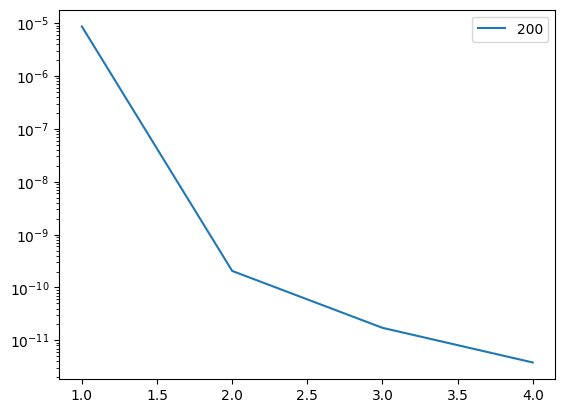

In [ ]:
fig, ax = plt.subplots()
for res in out:
    ax.plot(degs,res["errs"],label=f"{res["Nconv"]}")
    ax.axhline(0)
ax.set_yscale("log")
ax.legend()
# A = getA(fe,griglia,adisc,constantdiffusion=False)

plt.show()

### Test "visivo" che il metodo funziona

100%|██████████| 100/100 [00:00<00:00, 36427.86it/s]


  8%|▊         | 21/256 [00:08<01:36,  2.45it/s]Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x71f54afb9da0>
Traceback (most recent call last):
  File "/usr/lib/python3.13/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 
 20%|█▉        | 51/256 [00:22<01:32,  2.22it/s]


KeyboardInterrupt: 

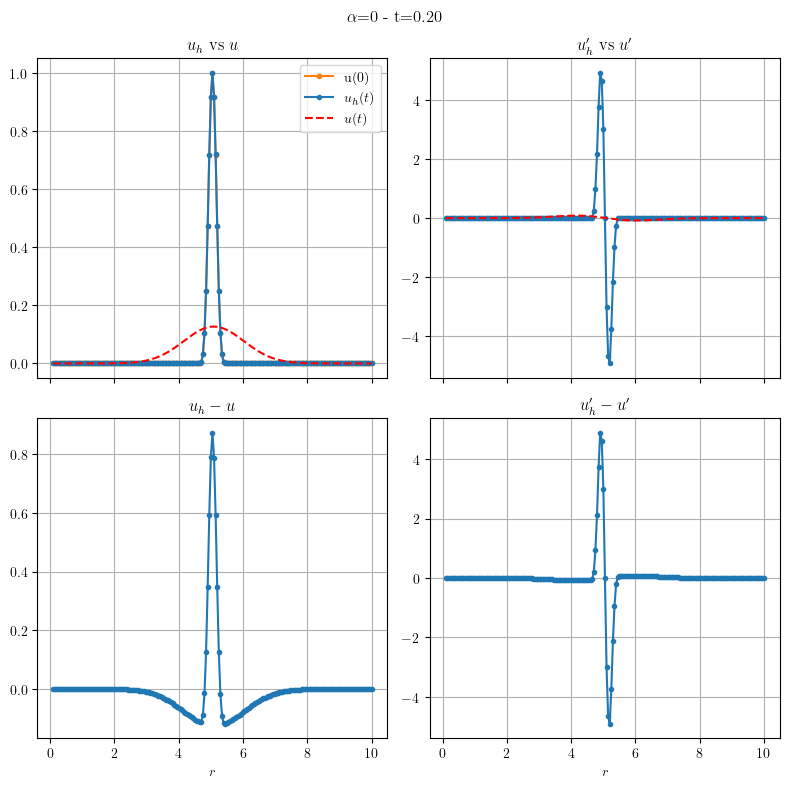

In [135]:
alpha = 0 # nu = A0/3 r^alpha
a, b = 0.1, 10 # estremi del dominio

T = 1 # tempo finale
Nt = 2**8 # numero di dt in T
dt = T/Nt # timestep
Nsnap = 100 # numero di figure intermedie salvate
dtplot = T/Nsnap # intervallo di tempo tra figure salvate

figfolder = f"graphics/filmini/alpha{alpha}_2" # cartella per le figure
Path(figfolder).mkdir(parents=True,exist_ok=True) # creala se non esiste

# condizione iniziale
mu = (b+a)/2 # centro
eps = (b-a)/50 # larghezza
f0 = lambda x: nicekernel(x,mu,eps) # uso funzione a supporto compatto
f0support = (mu-2*eps,mu+2*eps)

# scelgo A0 in modo che t sia già in unità di "tempo caratteristico diffusione"
# cioè 0<t<1 dovrebbe andare sempre bene per osservare evoluzione significativa
A0 = Astar(alpha=alpha,R0=mu) 

N = 100 # numero di elementi della griglia
h = (b-a)/N

ndof = 2 # numero di gradi di libertà polinomi
fe = FE(ndof) # inizializzo polinomi

griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
A = getA(fe,griglia,adisc,constantdiffusion=False,params=A0)

t = 0

X = griglia.globV



u = f0(X)

Nsteps = int(T/dt)
cycle = 0

grigliaconv = GRID(*f0support,1)

solveK, R = precompute_CN(griglia.M, A)

counter = 0
ts = []
for i in tqdm(range(Nsteps)):
    t+=dt
    ts.append(t)
    u = advance(u,dt,solveK,R)

    if np.floor(t/dtplot) > cycle:
        Yexact = discexact(X,t,f0,grigliaconv,alpha=alpha,progress=True,gaussdeg=10,A0=A0)
        if Yexact[0] > 0.1 or Yexact[-1] > 0.1:
            break
        Yexact_spline = make_splrep(X,Yexact,k=ndof,s=0)
        dYexact = Yexact_spline.derivative(1)(X)

        cycle += 1
        fig, ((ax,axd), (axerr1, axderr1)) = plt.subplots(nrows=2,ncols=2,figsize=(8,8),sharex=True)
        ax.plot(X,f0(X),".-C1",label="u(0)")
        u_spline = make_splrep(X,u,k=ndof,s=0)
        du_spline = u_spline.derivative(1)
        du = du_spline(X)

        ax.plot(X,u,'.-C0',label="$u_h(t)$")
        ax.plot(X,Yexact,'--r',label="$u(t)$")
        axerr1.plot(X,u-Yexact,".-C0")
        axerr1.set_xlabel("$r$")

        axd.plot(X,du,'.-C0',label="$u'_h(t)$")
        axd.plot(X,dYexact,'--r',label="$u'(t)")
        axderr1.plot(X,du-dYexact,".-C0")
        axderr1.set_xlabel("$r$")

        ax.set_title("$u_h$ vs $u$")
        axd.set_title("$u'_h$ vs $u'$")
        axerr1.set_title("$u_h-u$")
        axderr1.set_title("$u'_h-u'$")

        fig.suptitle(f"$\\alpha$={alpha} - t={t:0.2f}")
        ax.legend()
        ax.legend()
        ax.grid()
        axd.grid()
        axderr1.grid()
        axerr1.grid()
        # fix_lims(ax,(j==0))
        filename = f"{figfolder}/{counter:03d}.png"
        plt.tight_layout()
        fig.savefig(filename)
        plt.close()
        counter += 1

video_name = f"{figfolder}.mp4"
subprocess.run([
    "ffmpeg","-framerate","16", "-i",f"{figfolder}/%03d.png", "-pix_fmt","yuv420p",video_name, "-y"
])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 1/256 [00:18<1:17:56, 18.34s/it]


KeyboardInterrupt: 

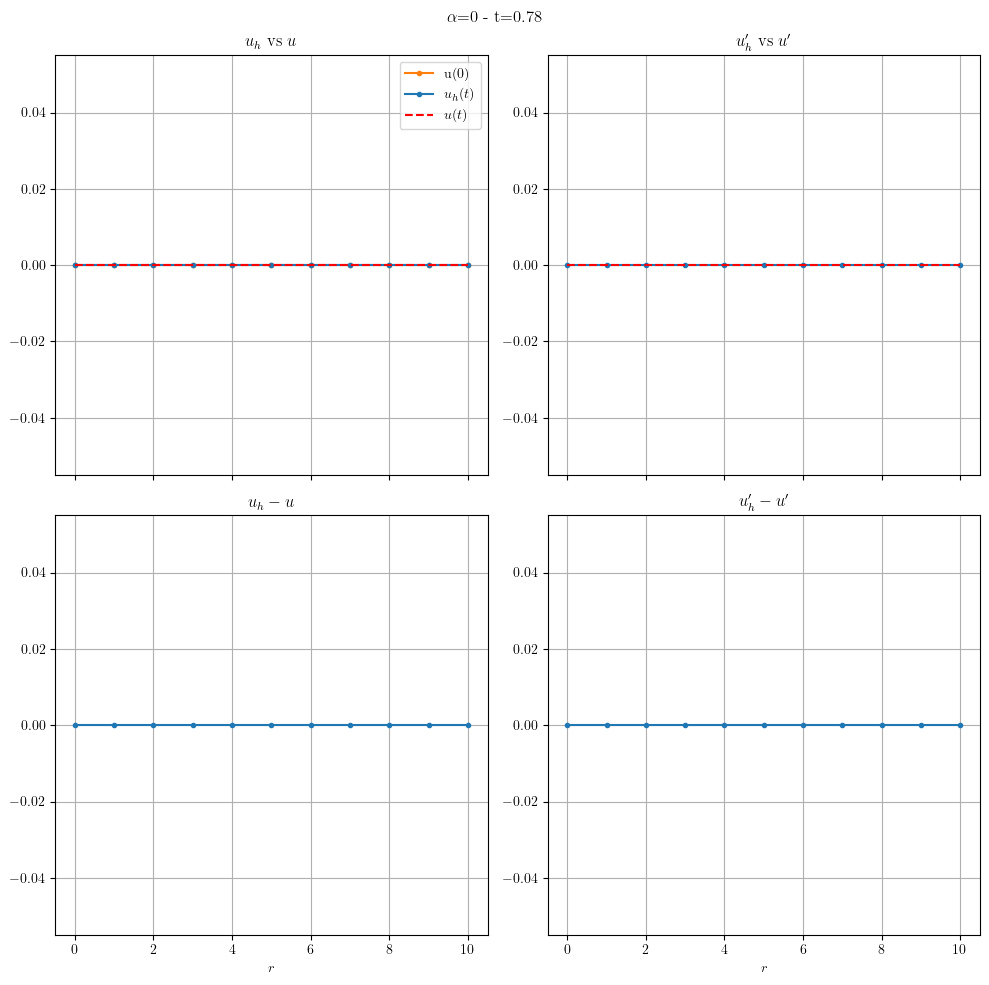

In [ ]:
alpha = 0 # nu = Ar^alpha
a, b = 0.0001, 10

T = 100
dt = T/2**8
Nsnap = 200
dtplot = T/Nsnap

figfolder = f"graphics/filmini/alpha{alpha}_2"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/curve.pkl"

eps = (b-a)/50*8
mu = (b+a)/2
mu = 0.01
eps = 0.002
f0 = lambda x: nicekernel(x,mu,eps)

N = 10
h = (b-a)/N

ndof = 1

counter = 0

out = []

with open("Yref1","rb") as f:
    exact = pickle.load(f)

with open("Ygood1","rb") as f:
    good = pickle.load(f)

fe = FE(ndof)

Yexact_spline = make_splrep(exact["X"],exact["Yref"],k=ndof,s=0)
Ygood_spline = make_splrep(good["X_good"],good["Y_good"],k=ndof,s=0)

dYexact_spline = Yexact_spline.derivative(1)
dYgood_spline = Ygood_spline.derivative(1)

griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
A = getA(fe,griglia,adisc,constantdiffusion=False)

t = 0

X = griglia.globV

ts = []

u = f0(X)

Nsteps = int(T/dt)
cycle = 0
grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,10)

solveK, R = precompute_CN(griglia.M, A)

for i in tqdm(range(Nsteps)):
    t+=dt
    ts.append(t)
    u = advance(u,dt,solveK,R)

    if np.floor(t/dtplot) > cycle:
        Yexact = discexact(X,t,f0,grigliaconv,alpha=alpha,approx=True)
        if Yexact[0] > 0.1 or Yexact[-1] > 0.1:
            break
        Yexact_spline = make_splrep(X,Yexact,k=ndof,s=0)
        dYexact = Yexact_spline.derivative(1)(X)

        cycle += 1
        fig, ((ax,axd), (axerr1, axderr1)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10),sharex=True)
        ax.plot(X,f0(X),".-C1",label="u(0)")
        u_spline = make_splrep(X,u,k=ndof,s=0)
        du_spline = u_spline.derivative(1)
        du = du_spline(X)

        ax.plot(X,u,'.-C0',label="$u_h(t)$")
        ax.plot(X,Yexact,'--r',label="$u(t)$")
        axerr1.plot(X,u-Yexact,".-C0")
        axerr1.set_xlabel("$r$")

        axd.plot(X,du,'.-C0',label="$u'_h(t)$")
        axd.plot(X,dYexact,'--r',label="$u'(t)")
        axderr1.plot(X,du-dYexact,".-C0")
        axderr1.set_xlabel("$r$")

        ax.set_title("$u_h$ vs $u$")
        axd.set_title("$u'_h$ vs $u'$")
        axerr1.set_title("$u_h-u$")
        axderr1.set_title("$u'_h-u'$")

        fig.suptitle(f"$\\alpha$={alpha} - t={t:0.2f}")
        ax.legend()
        ax.legend()
        ax.grid()
        axd.grid()
        axderr1.grid()
        axerr1.grid()
        # fix_lims(ax,(j==0))
        filename = f"{figfolder}/{counter:03d}.png"
        plt.tight_layout()
        fig.savefig(filename)
        plt.close()
        counter += 1

video_name = f"{figfolder}.mp4"
subprocess.run([
    "ffmpeg","-framerate","16", "-i",f"{figfolder}/%03d.png", "-pix_fmt","yuv420p",video_name, "-y"
])

### Scan su h

In [ ]:
alpha = 0 # nu = Ar^alpha
a, b = 10, 100

T = 10
dt = T/2**8
Nsteps = int(T/dt)

figfolder = f"graphics/scan/dt10spaziale{alpha}"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/curve.pkl"

Ns = 5*np.logspace(1,3,20).astype(int)
hs = (b-a)/Ns

eps = (b-a)/50*2
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

ndofs = np.arange(1,6)

counter = 0

out = []

with open("Yref1","rb") as f:
    exact = pickle.load(f)

if 0:
    ### calcolo Y esatta approssimata
    ndof_good = 3
    fe = FE(ndof_good)
    griglia_good = GRID(a,b,10000,ndof=ndof_good,getM=True,fe=fe)
    A = getA(fe,griglia_good,adisc,constantdiffusion=False)
    t = 0
    X_good = griglia_good.globV
    u = f0(X_good)
    ts = []
    for i in tqdm(range(Nsteps)):
        t+=dt
        u = advance(u,dt,griglia_good.M,A)
    Y_good = u
    good = {
    "X_good": X_good,
    "T": T,
    "Y_good": Y_good,
    "a": a,
    "b": b,
    "alpha": 0
}
    with open("Ygood2","wb") as f:
        pickle.dump(good,f)
else:
    with open("Ygood1","rb") as f:
        good = pickle.load(f)

for ndof in ndofs:
    fe = FE(ndof)
    us = []
    dus = []
    Ys = []
    dYs = []

    if 0:
        Yref_spline = make_splrep(exact["X"],exact["Yref"],k=ndof,s=0)
    if 1: 
        Yref_spline = make_splrep(good["X_good"],good["Y_good"],k=ndof,s=0)

    dYref_spline = Yref_spline.derivative(1)
    for j, N in enumerate(Ns):
        griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
        A = getA(fe,griglia,adisc,constantdiffusion=False)

        t = 0

        X = griglia.globV
        u = f0(X)
        # Y = discexact(X,T,f0,grigliaconv,alpha=alpha,approx=False)
        Y = Yref_spline(X)
        dY = dYref_spline(X)
        Ys.append(Y)
        dYs.append(dY)

        ts = []
        fig, ((ax,axd), (axerr, axderr)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
        ax.plot(X,u,".-C1",label="initial")
        for i in tqdm(range(Nsteps)):
            t+=dt
            ts = np.append(ts,t)
            u = advance(u,dt,griglia.M,A)
        
        us.append(u)
        u_spline = make_splrep(X,u,k=ndof,s=0)
        du_spline = u_spline.derivative(1)
        du = du_spline(X)
        dus.append(du)
        ax.plot(X,u,'.-C0',label="final")
        ax.plot(X,Y,'--r',label="exact")
        axerr.plot(X,u-Y,".-C0")

        axd.plot(X,du,'.-C0',label="final derivative")
        axd.plot(X,dY,'--r',label="exact derivative")
        axderr.plot(X,du-dY,".-C0")

        fig.suptitle(f"ndof={ndof}, N={N}")
        ax.legend()
        ax.grid()
        fix_lims(ax,(j==0))
        filename = f"{figfolder}/{counter:03d}.png"
        fig.savefig(filename)
        plt.close()
        counter += 1

        res = {
            "alpha": alpha,
            "T": T,
            "dt": dt,
            "Ns": Ns,
            "hs": hs,
            "ndof": ndof,
            "us": us,
            "dus": dus,
            "Ys": Ys,
            "dYs": dYs
        }

        if j==0:
            out.append(res)
        else:
            out[-1] = res
        with open(picklefile,"wb") as f:
            pickle.dump(out,f)

  0%|          | 0/256 [00:00<?, ?it/s]              

### scan dt


In [25]:
alpha = 0 # nu = Ar^alpha
a, b = 10, 100

T = 10
dts = T/2**np.arange(1,12)
print(dts)


figfolder = f"graphics/scan/dx1temporale{alpha}"
Path(figfolder).mkdir(parents=True,exist_ok=True)
picklefile = f"{figfolder}/curve.pkl"

N = 120
h = (b-a)/N

eps = (b-a)/50*2
mu = (b+a)/2
f0 = lambda x: nicekernel(x,mu,eps)

ndofs = np.arange(1,6)

counter = 0

out = []

with open("Yref1","rb") as f:
    exact = pickle.load(f)

with open("Ygood1","rb") as f:
    good = pickle.load(f)

for ndof in ndofs:
    fe = FE(ndof)
    us = []
    dus = []
    Ys = []
    dYs = []

    if 0:
        Yref_spline = make_splrep(exact["X"],exact["Yref"],k=ndof,s=0)
    if 1: 
        Yref_spline = make_splrep(good["X_good"],good["Y_good"],k=ndof,s=0)

    dYref_spline = Yref_spline.derivative(1)

    griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
    A = getA(fe,griglia,adisc,constantdiffusion=False)

    t = 0

    X = griglia.globV
    # Y = discexact(X,T,f0,grigliaconv,alpha=alpha,approx=False)
    Y = Yref_spline(X)
    dY = dYref_spline(X)

    ts = []

    for j, dt in enumerate(dts):
        Ys.append(Y)
        dYs.append(dY)
        u = f0(X)
        fig, ((ax,axd), (axerr, axderr)) = plt.subplots(nrows=2,ncols=2,figsize=(10,10))
        ax.plot(X,u,".-C1",label="initial")
        Nsteps = int(T/dt)
        for i in tqdm(range(Nsteps)):
            t+=dt
            ts = np.append(ts,t)
            u = advance(u,dt,griglia.M,A)
        us.append(u)
        u_spline = make_splrep(X,u,k=ndof,s=0)
        du_spline = u_spline.derivative(1)
        du = du_spline(X)
        dus.append(du)
        ax.plot(X,u,'.-C0',label="final")
        ax.plot(X,Y,'--r',label="exact")
        axerr.plot(X,u-Y,".-C0")

        axd.plot(X,du,'.-C0',label="final derivative")
        axd.plot(X,dY,'--r',label="exact derivative")
        axderr.plot(X,du-dY,".-C0")

        fig.suptitle(f"ndof={ndof}, {Nsteps} timesteps")
        ax.legend()
        ax.grid()
        fix_lims(ax,(j==0))
        filename = f"{figfolder}/{counter:03d}.png"
        fig.savefig(filename)
        plt.close()
        counter += 1

        res = {
            "alpha": alpha,
            "T": T,
            "ts": ts,
            "ndof": ndof,
            "us": us,
            "dus": dus,
            "Ys": Ys,
            "dYs": dYs
        }

        if j==0:
            out.append(res)
        else:
            out[-1] = res
        with open(picklefile,"wb") as f:
            pickle.dump(out,f)

[5.0000000e+00 2.5000000e+00 1.2500000e+00 6.2500000e-01 3.1250000e-01
 1.5625000e-01 7.8125000e-02 3.9062500e-02 1.9531250e-02 9.7656250e-03
 4.8828125e-03]


100%|██████████| 2048/2048 [00:25<00:00, 81.52it/s]


# Appendice

### Forme asintotiche Bessel per test approssimazione

In [ ]:
def iv_asymptotic(m,z):
    # formula asintotica per z grande
    b = m/z
    amplitude = 1/(np.sqrt(2*np.pi*z)*(1+b**2)**(1/4))
    exponential = np.exp(-m*np.arcsinh(b)+z*np.sqrt(1+b**2))
    return amplitude*exponential

def iv_stupid(z):
    # formula estremamente approssimata che è quella che vado ad usare poi
    # praticamente iv_asymptotic per a (ordine della Bessel) piccolo
    # la formula è esattamente iv_asymptotic per a=1/2
    amplitude = 1/(np.sqrt(2*np.pi*z))
    exponential = np.exp(z)
    return amplitude*exponential

### Debugging forma quadratica analitica $\alpha=0$

Ho calcolato la forma esatta della forma quadratica per il caso $\alpha=0$ e separando i contributi di $\mu$ e $\beta$ sono riuscito a trovare un bug nel codice. 

In [ ]:
ndof = 1# grado degli elementi finiti
fe = FE(ndof)
N = 100
rmin = 10 #raggio minimo 
rmax = 100
alpha = 0 # nu = Ar^alpha
 
a, b = rmin, rmax
griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)

def adisc(u,v,du,dv,xL=0,dx=1):
    #v in realtà non viene usata ma almeno c'è chiarezza
    mu = lambda r: r**alpha
    # mu = lambda r: 0
    b = lambda r: -(alpha-1/2)*r**(alpha-1)
    # b = lambda r: 0
    xrest = lambda r: xL+r*dx # dà x vero in funzione di x di riferimento
    return lambda r: (mu(xrest(r))*du(r)/dx-b(xrest(r))*u(r))*dv(r)

A = getA(fe,griglia,adisc,constantdiffusion=False)

x = griglia.V
h = griglia.ElemSize[0]

# solo diffusione (matrice standard perché in questo caso è costante)
Amu = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(N):
        if i==j:
            Amu[i,j] = 2/h #-1/h+ 1/(2*h**2)*(x[i-1]*np.log(x[i]/x[i-1])+x[i+1]*np.log(x[i+1]/x[i]))
        elif i==j+1:
            Amu[i,j] = -1/h #-1/(2*h) 1/(2*h**2)*x[i]*np.log(x[i]/x[j])
        elif j==i+1:
            Amu[i,j] = -1/h #+1/(2*h) 1/(2*h**2)*x[i]*np.log(x[i]/x[j])

# matrice completa
At = np.zeros((N+1,N+1))
for i in range(N):
    for j in range(N):
        if i==j:
            At[i,j] = 2/h -1/h+ 1/(2*h**2)*(x[i-1]*np.log(x[i]/x[i-1])+x[i+1]*np.log(x[i+1]/x[i]))
        elif i==j+1:
            At[i,j] = -1/h +1/(2*h) - 1/(2*h**2)*x[i]*np.log(x[i]/x[j])
        elif j==i+1:
            At[i,j] = -1/h +1/(2*h) + 1/(2*h**2)*x[i]*np.log(x[i]/x[j])

Amu = Amu[1:-1,1:-1]
At = At[1:-1,1:-1]
Ab = At-Amu
fig, ax = plt.subplots()
pos = ax.imshow(Ab-A)
fig.colorbar(pos)
plt.show()

up, center, down = [np.diag(At-A,k=k)/np.diag(Ab,k=k) for k in [-1,0,1]]

fig, ax = plt.subplots()
ax.plot(up,label="up")
ax.plot(center,label="center")
ax.plot(down,label="down")
ax.legend()
plt.show()

### Convergenza nel calcolo di A

Si vede che con quadratura di grado 4 si raggiunge sempre il plateau.

In [ ]:
fe = FE(ndof)
N = 10
rmin = 10 #raggio minimo 
rmax = 100
alpha = 1/2 # nu = Ar^alpha
 
a, b = rmin, rmax
ndofs = np.arange(1,10)
degs = np.arange(1,10)
out = []
for ndof in ndofs:
    griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
    Aref = getA(fe,griglia,adisc,constantdiffusion=False,gaussdeg=10)
    errs = []
    for deg in tqdm(degs,leave=False):
        A = getA(fe,griglia,adisc,constantdiffusion=False)
        err = np.sqrt(np.sum((A-Aref)**2))
        errs.append(err)
    errs = np.array(errs)
    res = {
        "errs": errs,
        "ndof": ndof
    }
    out.append(res)


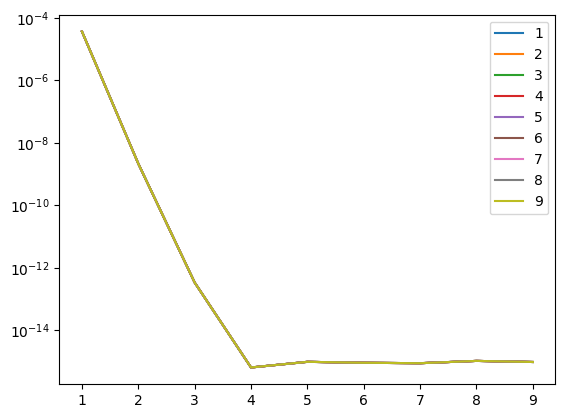

In [ ]:
fig, ax = plt.subplots()
for res in out:
    ax.plot(degs,res["errs"],label=f"{res["ndof"]}")
    ax.axhline(0)
ax.set_yscale("log")
ax.legend()
# A = getA(fe,griglia,adisc,constantdiffusion=False)

plt.show()

## Test preliminari su equazione del calore

### Soluzione esatta equazione del calore

In [ ]:
def aheat(u,v,du,dv,xL=0,dx=1):
    return lambda x: du(x)*dv(x)

def heatkernel(x,t,k):
    # funzione di green dell'equazione del calore, k diffusività
    return x*0 if t==0 else np.exp(-x**2/(4*k*t))/np.sqrt(4*np.pi*k*t)

def heatexact(x,t,k,g,grigliaconv):
    # soluzione esatta equazione del calore con integrazione gaussiana
    y = x*0
    for i in tqdm(range(len(x))):
        xvar = x[i]
        y[i] = grigliaconv.integrate(lambda y: g(y)*heatkernel(xvar-y,t,k))
    return y
    
def heatexactconv(x,t,k,g):
    # soluzione esatta equazione del calore con convoluzione di scipy
    kernel = heatkernel(x-(b-a)/2,t,k)
    G = g(X)
    return convolve(G,kernel,mode="same")/np.sum(kernel)

### Test su equazione del calore
La miglior condizione iniziale è quella $C^2$ a supporto compatto per velocizzare il calcolo della soluzione esatta (collo di bottiglia).

100%|██████████| 101/101 [00:00<00:00, 641.26it/s]


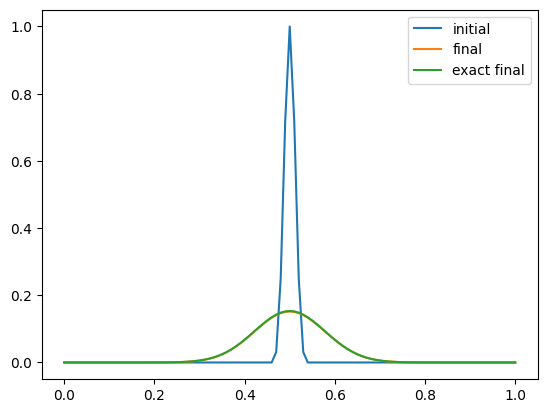

In [ ]:
ndof = 4
a, b = 0, 1
fe = FE(ndof)
griglia = GRID(a,b,25,ndof=ndof,getM=True,fe=fe)
A = getA(fe,griglia,aheat,constantdiffusion=True)

p = fe.Pol
dt = 0.00001
t = 0
eps = (b-a)/50
Nsteps = 300

# f0 = lambda x: np.exp(-(x-(a+b)/2)**2/eps**2)
# f0 = lambda x: gauss(x,(b-a)*0.4,eps)+ gauss(x, (b-a)*0.6,eps) 
f0 = lambda x: nicekernel(x,(b+a)/2,eps)
# f0 = lambda x: waterbag(x,(a+b)/2,eps)
X = griglia.globV
u = f0(X)
ts = []
fig, ax = plt.subplots()
ax.plot(X,u,label="initial")
for i in tqdm(range(Nsteps)):
    t+=dt
    ts = np.append(ts,t)
    u = advance(u,dt,griglia.M,A)
ax.plot(X,u,label="final")
k=1

grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,5)
Y = heatexact(X,t,k,f0,grigliaconv)
ax.plot(X,Y,label="exact final")

if t==0:
    t=1
# Yc = heatexactconv(X,t,k,f0)
# ax.plot(X,Yc,label="convolve final")
ax.legend()

plt.show()

## Test convergenza su equazione del calore

### Convergenza spaziale

In [ ]:
a, b = 0, 1
dt = 2**1*1e-6
T = 2**12*1e-6
Nsteps = int(T/dt)

figfolder = "graphics/convergenza_spaziale"
Path(figfolder).mkdir(parents=True,exist_ok=True)

Ns = 5*np.logspace(1,2,10).astype(int)
hs = (b-a)/Ns

eps = (b-a)/50*2
f0 = lambda x: nicekernel(x,(b+a)/2,eps)
grigliaconv = GRID((b+a)/2-2*eps,(b+a)/2+2*eps,50)

ndofs = np.arange(1,5)
fe = FE(ndof)

k = 1

errs_ndofs = []
counter = 0
for ndof in ndofs:
    fe = FE(ndof)
    errs = []

    for j, N in enumerate(Ns):
        griglia = GRID(a,b,N,ndof=ndof,getM=True,fe=fe)
        A = getA(fe,griglia,aheat,constantdiffusion=True)
        
        t = 0

        X = griglia.globV
        u = f0(X)
        ts = []
        fig, ax = plt.subplots()
        ax.plot(X,u,label="initial")
        for i in range(Nsteps):
            t+=dt
            ts = np.append(ts,t)
            u = advance(u,dt*(b-a),griglia.M,A)
        
        Y = heatexact(X,t,k,f0,grigliaconv)
        err = np.sqrt(np.sum((u-Y)**2))
        errs.append(err)
        ax.plot(X,u,label="final")
        ax.plot(X,Y,label="exact final")
        ax.set_title(f"ndof={ndof}, N={N}")
        ax.legend()
        ax.grid()
        filename = f"{figfolder}/{counter:03d}.png"
        fig.savefig(filename)
        plt.close()
        counter += 1

    errs = np.array(errs)
    errs_ndofs.append(errs)

with open("h.pkl","wb") as f:
    pickle.dump(errs,f)

  0%|          | 0/301 [00:00<?, ?it/s]

100%|██████████| 2001/2001 [00:41<00:00, 48.67it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'h.pickle'

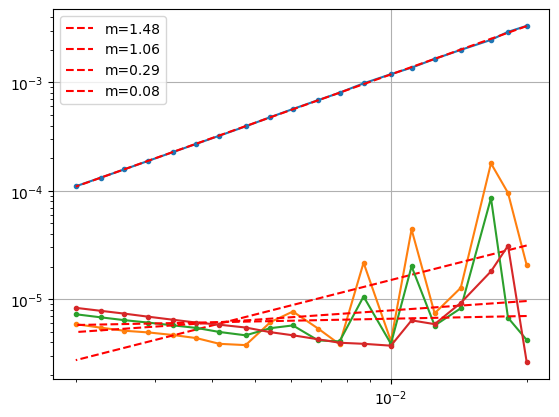

In [ ]:
with open("h.pkl","rb") as f:
    errs = pickle.load(f)

fig, ax = plt.subplots()

for errs in errs_ndofs:
    Xfit = np.log10(hs)
    Yfit = np.log10(errs)
    popt, _ = curve_fit(line,Xfit,Yfit)
    ax.plot(hs,errs,'.-')
    ax.plot(hs,10**line(Xfit,*popt),'--r',label=f"m={popt[0]:0.2f}")
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()

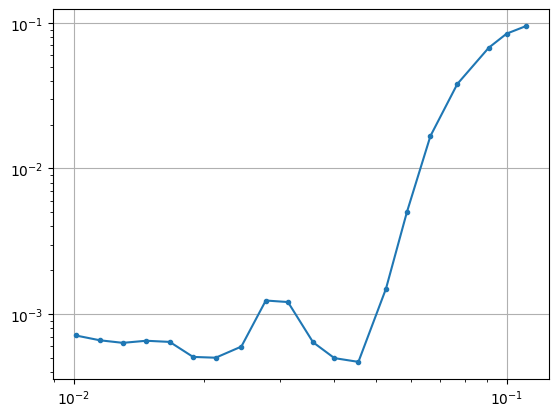

In [ ]:
fig, ax = plt.subplots()
Xfit = np.log10(hs)
Yfit = np.log10(errs)
# popt, _ = curve_fit(line,Xfit,Yfit)
ax.plot(hs,errs,'.-C0')
# ax.plot(hs,10**line(hs,*popt),'--C1')
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
plt.show()